In [1]:
import scanpy as sc
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append(str(Path.cwd().parent))
from utils.adata import *
from utils.latent import *
from utils.plot import *
from utils.evaluation import *
import json
from sklearn.neighbors import NearestNeighbors
from umap import UMAP
import torch
import torch.nn.functional as F
import anndata
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.decomposition import PCA
from src.scDiffusion import VAE, guided_diffusion
from src.scDiffusion.VAE.VAE_model import *
import glob

In [2]:
adata = sc.read_h5ad("../data/emt.h5ad")

In [3]:
adata.obs["celltype"] = adata.obs["cell_type"].map(
    {"Epithelial": "Epi", "Mesenchymal": "Mes"}
)
adata.obs["celltype"] = adata.obs["celltype"].astype("category")

In [4]:
adata.obs["period"] = adata.obs["celltype"]

In [5]:
adata.write("../data/emt_diff.h5ad")

In [40]:
adata

AnnData object with n_obs × n_vars = 5027 × 2000
    obs: 'cell', 'total_umis', 'sample', 'TSNE.1', 'TSNE.2', 'Size_Factor', 'treatment_id', 'spatial_id', 'cell_type', 'dpt_pseudotime', 'celltype', 'period'
    var: 'id', 'gene_short_name', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'X_name', 'cell_type_colors', 'diffmap_evals', 'hvg', 'iroot', 'neighbors', 'pca', 'umap'
    obsm: 'X_diffmap', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

### Train the SCimilarity VAE

In [ ]:
!python ../src/scDiffusion/VAE/VAE_train.py \
--data_dir '../data/emt_diff.h5ad' \
--num_genes 2000 \
--save_dir '../models/scdiff/emt/VAE' \
--state_dict '../models/scdiff/annotation_model_v1/' \
--max_steps 200000


loading pretrained model from: 
 {'encoder': '../models/scdiff/annotation_model_v1/encoder.ckpt', 'decoder': '../models/scdiff/annotation_model_v1/decoder.ckpt', 'gene_order': '../models/scdiff/annotation_model_v1/gene_order.tsv'}
/mnt/home/islamsa3/anaconda3/envs/global/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)
step  0 loss  1.4337416887283325
step  1000 loss  0.2901614010334015
step  2000 loss  0.25145766139030457
step  3000 loss  0.2434931993484497
step  4000 loss  0.21504704654216766
step  5000 loss  0.20773711800575256
step  6000 loss  0.19371017813682556
step  7000 loss  0.1876397430896759
step  8000 loss  0.17543569207191467
step  9000 loss  0.17463421821594238
step  10000 loss  0.16368670761585236
step  11000 loss  0.15742330253124237
step  120

### Train the diffusion backbone

In [ ]:
!python ../src/scDiffusion/cell_train.py \
  --data_dir '../data/emt_diff.h5ad' \
  --vae_path '../models/scdiff/emt/VAE/model_seed=0_step=199999.pt' \
  --model_name 'diffusion' \
  --save_dir '../models/scdiff/emt' \
  --batch_size 128 \
  --lr 0.5e-5 \
  --lr_anneal_steps 20000

Logging to ../models/scdiff/emt/diffusion/logs/diffusion
creating model and diffusion...
creating data loader...
training...
/mnt/home/islamsa3/anaconda3/envs/global/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)
-------------------------
| grad_norm  | 0.878    |
| loss       | 1.13     |
| loss_q0    | 1.17     |
| loss_q1    | 1.12     |
| loss_q2    | 1.27     |
| loss_q3    | 1.28     |
| mse        | 1.13     |
| mse_q0     | 1.17     |
| mse_q1     | 1.12     |
| mse_q2     | 1.27     |
| mse_q3     | 1.28     |
| param_norm | 79       |
| samples    | 128      |
| step       | 0        |
-------------------------
saving model 0...
saving model 0.9999...
-------------------------
| grad_norm  | 0.643    |
| loss       | 1.02     |
| loss_q0    | 0.95

In [5]:
device     = "cuda" if torch.cuda.is_available() else "cpu"
batch_size = 512
num_cells, num_genes = adata.shape

In [6]:
X = adata.X
if not isinstance(X, np.ndarray):
    X = X.toarray()

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
X = adata.X
if not isinstance(X, np.ndarray):
    X = X.toarray()

/mnt/home/islamsa3/anaconda3/envs/global/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


In [7]:
latent_dim = 128  

model = VAE(
    num_genes=num_genes,
    hidden_dim=latent_dim,
    device=device,
    seed=0,
    decoder_activation="ReLU",
)
state = torch.load('../models/scdiff/emt/VAE/model_seed=0_step=199999.pt', map_location=device)
model.load_state_dict(state)
model.to(device)
model.eval()

VAE(
  (encoder): Encoder(
    (network): ModuleList(
      (0): Sequential(
        (0): Dropout(p=0.0, inplace=False)
        (1): Linear(in_features=2000, out_features=1024, bias=True)
        (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): PReLU(num_parameters=1)
      )
      (1-2): 2 x Sequential(
        (0): Dropout(p=0.0, inplace=False)
        (1): Linear(in_features=1024, out_features=1024, bias=True)
        (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): PReLU(num_parameters=1)
      )
      (3): Linear(in_features=1024, out_features=128, bias=True)
    )
  )
  (decoder): Decoder(
    (network): ModuleList(
      (0): Sequential(
        (0): Linear(in_features=128, out_features=1024, bias=True)
        (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): PReLU(num_parameters=1)
      )
      (1-2): 2 x Sequential(
        (

In [8]:
X_latent = np.zeros((num_cells, latent_dim), dtype=np.float32)

with torch.no_grad():
    for start in range(0, num_cells, batch_size):
        end = min(start + batch_size, num_cells)
        batch = torch.tensor(X[start:end], dtype=torch.float32, device=device)

        z = model.encoder(batch)    

        X_latent[start:end] = z.cpu().numpy()

### Train the classifier

In [ ]:
!python ../src/scDiffusion/classifier_train.py \
  --data_dir '../data/emt_diff.h5ad' \
  --vae_path '../models/scdiff/emt/VAE/model_seed=0_step=199999.pt' \
  --model_path '../models/scdiff/emt/classifier/' \
  --num_class 2 \
  --batch_size 64 \
  --iterations 10000 \
  --lr 1e-3 \
  --weight_decay 0.0 \
  --log_interval 100 \
  --save_interval 1000 \
  --noised False

Logging to /tmp/openai-2025-12-11-00-57-28-467648
creating model and diffusion...
Running in single GPU mode without DDP
creating data loader...
creating optimizer...
training classifier model...
/mnt/home/islamsa3/anaconda3/envs/global/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)
-----------------------------
| grad_norm      | 2.79     |
| param_norm     | 49.8     |
| samples        | 64       |
| step           | 0        |
| train_acc@1    | 0.547    |
| train_acc@1_q0 | 0        |
| train_loss     | 0.696    |
| train_loss_q0  | 0.871    |
-----------------------------
-----------------------------
| grad_norm      | 1.01     |
| param_norm     | 50       |
| samples        | 6.46e+03 |
| step           | 100      |
| train_acc@1    | 0.875    |
| t

: 

### Generate Trajectory

In [10]:
!python ../src/scDiffusion/classifier_sample.py 

Logging to /tmp/openai-2025-12-11-18-41-04-709113
creating model and diffusion...
loading classifier...
/mnt/home/islamsa3/anaconda3/envs/global/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)
sampling...
step  0
step  200
step  400
step  600
step  800
created 128 samples
step  0
step  200
step  400
step  600
step  800
created 256 samples
Saved 256 cells to ../data/generated/interpolation_0.npz
sampling complete
Logging to /tmp/openai-2025-12-11-18-41-21-703780
creating model and diffusion...
loading classifier...
sampling...
step  0
step  200
step  400
step  600
step  800
created 128 samples
step  0
step  200
step  400
step  600
step  800
created 256 samples
Saved 256 cells to ../data/generated/interpolation_1.npz
sampling complete
Logging to /tmp/openai-20

In [11]:
paths = sorted(
    glob.glob("../data/generated/interpolation_*.npz"),
    key=lambda x: int(x.split("_")[-1].split(".")[0])
)
paths

['../data/generated/interpolation_0.npz',
 '../data/generated/interpolation_1.npz',
 '../data/generated/interpolation_2.npz',
 '../data/generated/interpolation_3.npz',
 '../data/generated/interpolation_4.npz',
 '../data/generated/interpolation_5.npz',
 '../data/generated/interpolation_6.npz',
 '../data/generated/interpolation_7.npz',
 '../data/generated/interpolation_8.npz',
 '../data/generated/interpolation_9.npz',
 '../data/generated/interpolation_10.npz']

In [15]:
Z_list = []
step_list = []

for i, path in enumerate(paths):
    d = np.load(path)
    z_i = d["cell_gen"]          
    Z_list.append(z_i)
    step_list.append(np.full(z_i.shape[0], i, dtype=int))  

Z = np.vstack(Z_list)            
steps = np.concatenate(step_list)

In [21]:
N_target = 200
N_total = Z.shape[0]

idx = np.linspace(0, N_total - 1, N_target).astype(int)

Z = Z[idx]

In [22]:
with torch.no_grad():
    z_t = torch.tensor(Z, dtype=torch.float32, device=device)

    X_syn = model.decoder(z_t)

    X_syn = X_syn.cpu().numpy() 

In [24]:
adata_interpolated_cells = anndata.AnnData(X_syn)

In [25]:
adata_interpolated_cells.var_names = adata.var_names
adata_interpolated_cells.obs['cell_type'] = 'Interpolated'

In [26]:
combined_adata = combine_adatas(adata, adata_interpolated_cells)

/mnt/home/islamsa3/anaconda3/envs/global/lib/python3.10/site-packages/scanpy/neighbors/__init__.py:577: UserWarning: You’re trying to run this on 2000 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  x = _choose_representation(self._adata, use_rep=use_rep, n_pcs=n_pcs)


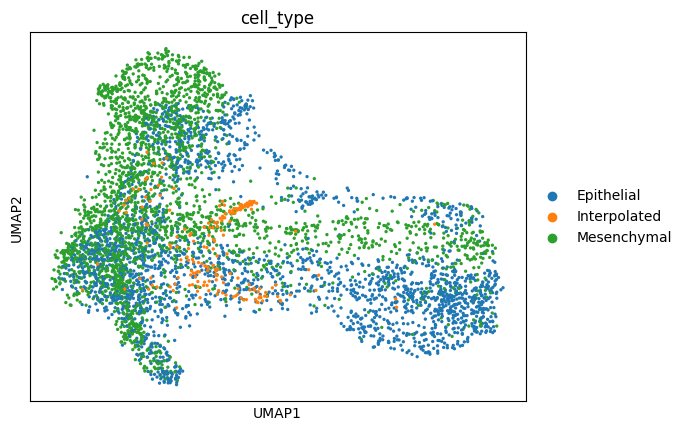

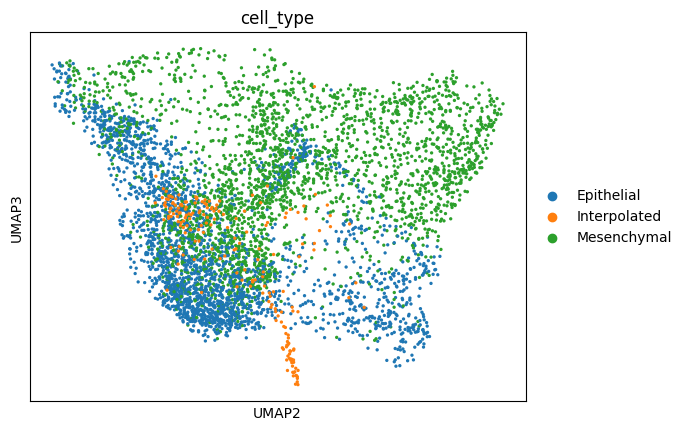

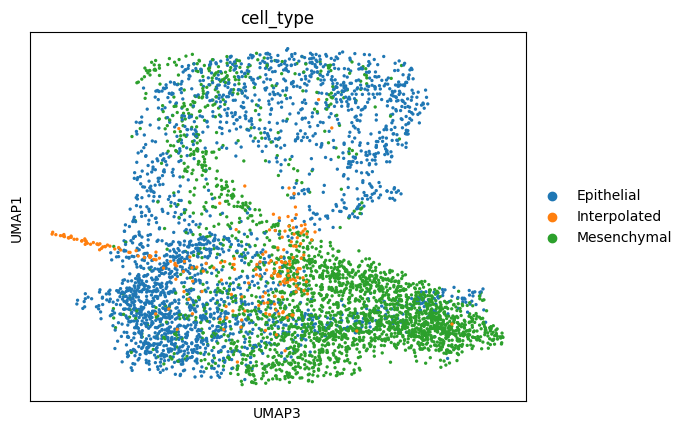

In [27]:
plot_umap(combined_adata, 'cell_type')

Available epithelial markers: ['CDH1', 'CRB3', 'DSP']
Available mesenchymal markers: ['VIM', 'FN1', 'SNAI2']


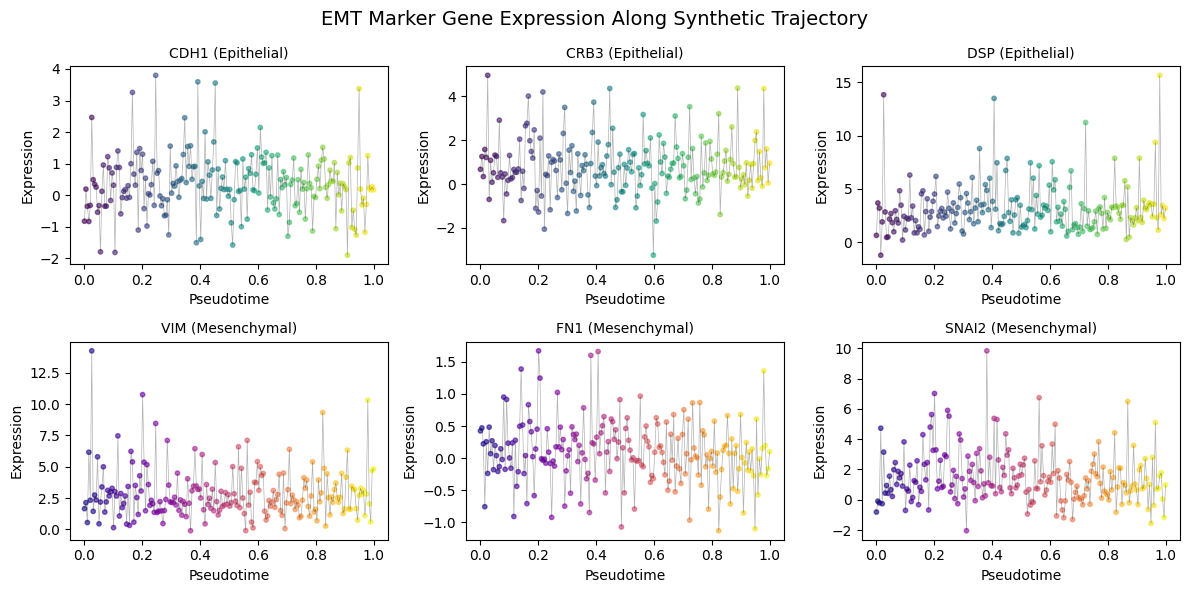

In [29]:
epithelial_markers = ['CDH1', 'CRB3', 'DSP']
mesenchymal_markers = ['VIM', 'FN1', 'SNAI2']

gene_names = adata.var['gene_short_name'].values if 'gene_short_name' in adata.var else adata.var_names.values

available_epithelial = [g for g in epithelial_markers if g in gene_names]
available_mesenchymal = [g for g in mesenchymal_markers if g in gene_names]

print(f"Available epithelial markers: {available_epithelial}")
print(f"Available mesenchymal markers: {available_mesenchymal}")

if available_epithelial or available_mesenchymal:
    n_markers = len(available_epithelial) + len(available_mesenchymal)
    n_cols = 3
    n_rows = 2
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows))
    axes = axes.flatten() if n_markers > 1 else [axes]
    
    pseudotime = np.linspace(0,1,len(X_syn))
    
    plot_idx = 0
    for gene in available_epithelial:
        gene_idx = np.where(gene_names == gene)[0][0]
        expression = X_syn[:, gene_idx]
        
        ax = axes[plot_idx]
        ax.scatter(pseudotime, expression, c=pseudotime, cmap='viridis', s=10, alpha=0.6)
        ax.plot(pseudotime, expression, 'k-', alpha=0.3, linewidth=0.5)
        ax.set_xlabel('Pseudotime')
        ax.set_ylabel('Expression')
        ax.set_title(f'{gene} (Epithelial)', fontsize=10)
        plot_idx += 1
    
    for gene in available_mesenchymal:
        gene_idx = np.where(gene_names == gene)[0][0]
        expression = X_syn[:, gene_idx]
        
        ax = axes[plot_idx]
        ax.scatter(pseudotime, expression, c=pseudotime, cmap='plasma', s=10, alpha=0.6)
        ax.plot(pseudotime, expression, 'k-', alpha=0.3, linewidth=0.5)
        ax.set_xlabel('Pseudotime')
        ax.set_ylabel('Expression')
        ax.set_title(f'{gene} (Mesenchymal)', fontsize=10)
        plot_idx += 1
    
    for i in range(plot_idx, len(axes)):
        axes[i].set_visible(False)
    
    plt.suptitle('EMT Marker Gene Expression Along Synthetic Trajectory', fontsize=14)
    plt.tight_layout()
    plt.show()
else:
    print("No common EMT markers found in the dataset")

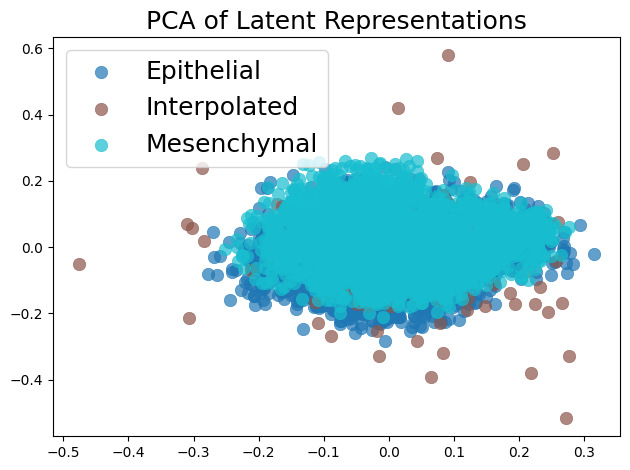

In [31]:
original_labels = adata.obs['cell_type'].values
interpolated_labels = np.array(['Interpolated'] * len(adata_interpolated_cells))

combined_latent = np.vstack([X_latent, Z])
combined_labels = np.concatenate([original_labels, interpolated_labels])

pca = PCA(n_components=2, random_state=42)
latent_pca = pca.fit_transform(combined_latent)


unique_labels = np.unique(combined_labels)

unique_colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))
palette = {label: unique_colors[i] for i, label in enumerate(unique_labels)}

for i, label in enumerate(unique_labels):
    mask = combined_labels == label
    plt.scatter(
        latent_pca[mask, 0], 
        latent_pca[mask, 1],
        color=palette[label],
        label=label,
        alpha=0.7,
        s=50 if label == 'interpolated' else 80,
        #edgecolors='w',
        linewidths=0.5
    )

plt.title('PCA of Latent Representations', fontsize=18)
plt.legend(fontsize=18)
plt.tight_layout()

/mnt/home/islamsa3/anaconda3/envs/global/lib/python3.10/site-packages/scanpy/neighbors/__init__.py:577: UserWarning: You’re trying to run this on 128 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  x = _choose_representation(self._adata, use_rep=use_rep, n_pcs=n_pcs)


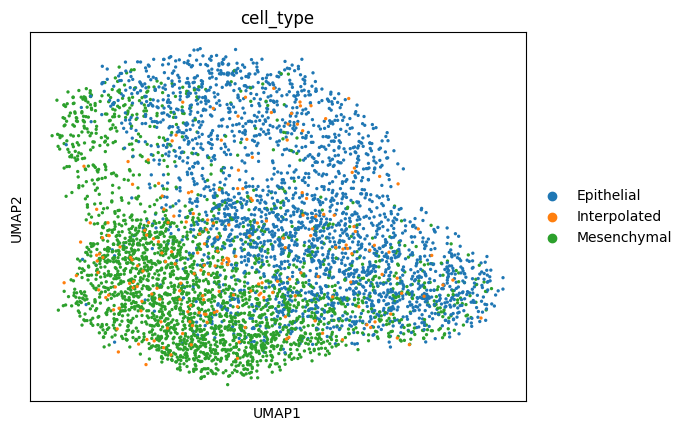

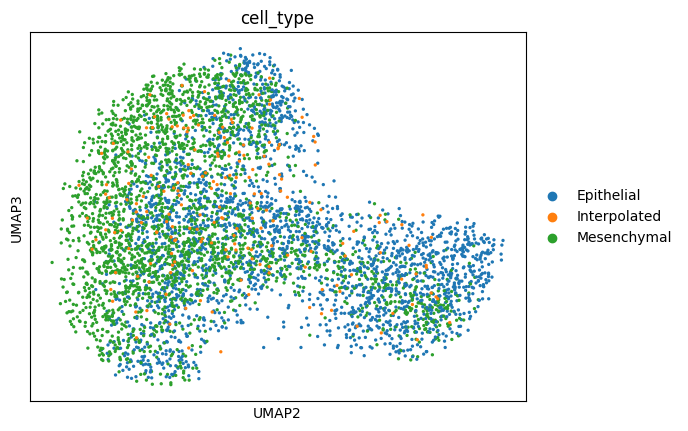

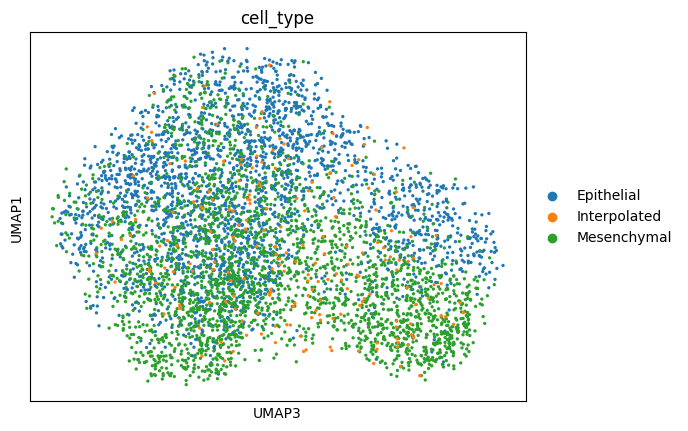

In [32]:
adata_latent_syn = anndata.AnnData(Z)
adata_latent_syn.obs["cell_type"] = "Interpolated"
adata_new = anndata.AnnData(
    X=X_latent,
    obs=adata.obs[['cell_type']].copy()
)
combined_adata_latent = combine_adatas(adata_new, adata_latent_syn)
plot_umap(combined_adata_latent, "cell_type")

In [33]:
pt_df, pt_summary = evaluate_pseudotime_distance_error(
    X_syn,
    np.linspace(0, 1, len(X_syn)),
    adata,
    list(gene_names),
    real_pseudotime_key="dpt_pseudotime",
)

print(pt_summary)
pt_df.head()

{'delta_t_mean': 0.3297181390922273, 'delta_t_median': 0.2860691996675041, 'delta_t_max': 0.9247162288157784, 'dist_mean': 43.46938416481018, 'dist_median': 34.31162452697754, 'dist_max': 185.97674560546875}


,alpha,nearest_pseudotime,delta_t,dist_to_nearest
0,0.000000,0.767883,0.767883,40.424618
1,0.005025,0.777732,0.772707,40.343544
2,0.010050,0.651486,0.641436,31.153559
3,0.015075,0.779506,0.764431,58.462078
4,0.020101,0.713859,0.693758,31.056850


In [34]:
dist_series, dist_summary = evaluate_distance_to_manifold_smoothness(
    X_syn,
    adata,
    list(gene_names),
)

print(dist_summary)

{'dist_mean': 43.46938416481018, 'dist_median': 34.31162452697754, 'dist_max': 185.97674560546875, 'smooth_mean_abs_delta': 22.332632093573334, 'smooth_max_abs_delta': 158.3912353515625}


In [36]:
marker_sets = {
    "Epithelial": ["CDH1", "CRB3", "DSP"],
    "Mesenchymal": ["VIM", "FN1", "SNAI2"],
}

expected_directions = {
    "Epithelial": -1,   
    "Mesenchymal": 1,   
}

df_markers, summary_markers = evaluate_marker_monotonicity_general(
    X_syn=X_syn,
    traj_coord=np.linspace(0, 1, len(X_syn)),      
    gene_list=list(gene_names),
    marker_sets=marker_sets,
    expected_directions=expected_directions,

)

print(summary_markers)
df_markers.head()

         group  n_genes  mean_rho  median_rho  frac_sign_ok
0   Epithelial        3  0.020628   -0.008085      0.666667
1  Mesenchymal        3 -0.077622   -0.117267      0.333333


,group,gene,rho,pval,expected_dir,sign_ok
0,Epithelial,CDH1,-0.012060,0.865407,-1,True
1,Epithelial,CRB3,-0.008085,0.909533,-1,True
2,Epithelial,DSP,0.082030,0.248193,-1,False
3,Mesenchymal,VIM,0.019004,0.789395,1,True
4,Mesenchymal,FN1,-0.134603,0.057394,1,False


In [ ]:
adata_interpolated_cells.write_h5ad('../data/syn_emt_scdiff.h5ad')

: 